# UNKNOWN METRIC

In [1]:
%matplotlib inline
import sys,os
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')
import numpy as np
import math
from scipy.stats import norm, uniform,ks_2samp
from scipy.misc import factorial2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.utils import shuffle
from scipy.stats import *
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from builtins import zip
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils import m52snr, sigma_slope, astrom_precision
import glob
import os
from opsimUtils import *
from astropy.io import fits
from astropy.stats import bayesian_blocks
import time
import seaborn as sns

In [2]:
your_username = 'fragosta'

In [3]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.4/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/PM'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
dbRuns = show_opsims(dbDir)

In [4]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [5]:
class TransienPM(BaseMetric):
#    Generate a population of transient objects and see what is its proper motion \n",
    def __init__(self, metricName='TransienPM', nexp=100, Mmin=10, Mmax=28, U=np.arange(-400,400,25), f='g', snr_lim=5,
             V=np.arange(-600,200,25),W=np.arange(-400,400,25),m5Col='fiveSigmaDepth', 
             mjdCol='observationStartMJD',filterCol='filter',seeingCol='seeingFwhmGeom', surveyduration=10, **kwargs):
        self.mjdCol = mjdCol
        self.seeingCol= seeingCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nexp = nexp
        self.snr_lim = snr_lim
        self.f = f
        self.U=U
        self.V=V
        self.W=W
        self.Mmin= Mmin
        self.Mmax= Mmax
        self.surveyduration = surveyduration 
        super(TransienPM, self).__init__(col=[self.mjdCol, self.m5Col,self.seeingCol, self.filterCol],
                                                  units='Fraction Detected',
                                                  metricName=metricName, **kwargs)

    # typical velocity distribution from litterature (Binney et Tremain- Galactic Dynamics)
    def DF(self,V_matrix, mode):
        U,V,W=V_matrix[:][0],V_matrix[:][1],V_matrix[:][2]
        if mode== 'H':
            norm=0.02
            Va=200
            P=norm*np.exp(-((U/130)**2+((V-Va)/105)**2+(W/85)**2)/2)/np.sqrt(2*np.pi)/(130*105*85)
        elif mode=='B':
            norm=0.05
            Va=100
            P=norm*np.exp(-((U/120)**2+((V-Va)/95)**2+(W/75)**2)/2)/np.sqrt(2*np.pi)/(120*95*75)
        elif mode=='D':
            norm=0.98
            Va=10
            P=norm*np.exp(-((U/40)**2+((V-Va)/30)**2+(W/20)**2)/2)/np.sqrt(2*np.pi)/(40*30*20)
        return P

    def lightCurve(self, t, t0, peak, duration, slope):
#      A simple top-hat light curve.,
#        
#        Parameters\n",
#        ----------\n",
#        t : array\n",
#            Times to generate lightcurve points (mjd)\n",
#        t0 : float\n",
#            Initial time (mjd)\n",
#        m_r_0 : float\n",
#            initial r-band brightness (mags)\n",
        lightcurve = np.zeros(np.size(t), dtype=float) + 99.
# Select only times in the lightcurve duration window\n",
        good = np.where( (t >= t0) & (t <= t0+duration) )
        lightcurve[good] = peak + slope*(t[good]-t0)
        return lightcurve

    def run(self,  dataSlice, slicePoint=None):
        obs = np.where((dataSlice['filter']==self.f) & (dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration))
        names=['PM', 'PM_out','snr','timegap']
        variables = {k:[] for k in names}
        vel_out= uniform(-5000,5000)
        if len(dataSlice[self.m5Col][np.where(dataSlice['filter'][obs]==self.f)])>2: 
            for s in range(self.nexp):    
                tf = dataSlice[self.mjdCol][np.where(dataSlice['filter'][obs]==self.f)]
                dT = np.absolute(tf - shuffle(tf)) # dd                                                                          
                see=np.median(dataSlice[self.seeingCol]) # arcsec
                M = np.random.uniform(self.Mmax, self.Mmin)  # magAB                                                                        
                d = np.random.uniform(4, 1.2*10**5) # pc                                                                                 
                #### velocity distribution###                
                mode=''
                pos = np.random.rand()
                if pos <=1/3:
                    mode='B'
                elif pos>1/3 and pos<=2/3:
                    mode='D'
                elif pos>2/3 and pos<=1:
                    mode='H'
                V_matrix=np.vstack((self.U,self.V,self.W))
                velmat = np.zeros(len(V_matrix))
                veloutmat = np.zeros(len(V_matrix))
                Pv=self.DF(V_matrix, mode)
                Pord=np.sort(Pv)
                row=np.where(Pv==np.random.choice(Pord))

                for i in range(len(V_matrix)):
                    velmat[i]=V_matrix[i][row]
                    veloutmat[i]=vel_out.rvs()

                if mode=='B' or mode=='H':     
                    vT = np.sqrt(velmat[1]**2+velmat[2]**2)
                    vfT = np.sqrt(veloutmat[1]**2+veloutmat[2]**2)
                else:
                    vT = velmat[1]
                    vfT = veloutmat[1]

                mu= vT/4.75/d
                muf=vfT/4.75/d
                arc=muf*dT/365
                for i,a in enumerate(arc):
                    if a > 0.05*see and M<27:
                        variables['timegap'].append(dT[i])
                        variables['PM_out'].append(muf)
                        variables['PM'].append(mu)
                        variables['snr'].append(m52snr(M,np.median(dataSlice[self.m5Col][np.where(dataSlice['filter']==self.f)])))
                    else:
                        variables['timegap'].append(np.nan)
                        variables['PM_out'].append(np.nan)
                        variables['PM'].append(np.nan)
                        variables['snr'].append(np.nan)


        variables = {k:np.array([elem for elem in v if elem is not np.nan]) for k,v in variables.items()}                     
        objRate = 0.7 # how many go off per day\n",
        # decide how many objects we want to generate\n",
        nObj=len(variables['PM'])
        m0s = np.random.uniform(self.Mmax, self.Mmin, nObj)
        t = dataSlice[self.mjdCol][obs] - dataSlice[self.mjdCol].min()
        detected = np.zeros(variables['timegap'].size)
        # Loop though each generated transient and decide if it was detected\n",
        # This could be a more complicated piece of code, for example demanding \n",
        # A color measurement in a night.\n",
        
        for i,duration in enumerate(variables['timegap']):
            t0 = np.random.uniform(0,10)
            slope = np.random.uniform(-3,3)
            lc = self.lightCurve(t, t0, m0s[i],duration, slope)
            good = m52snr(lc,dataSlice[self.m5Col][obs])> self.snr_lim
            detectTest = dataSlice[self.m5Col][obs] - lc
            if detectTest.max() > 0 and len(good)>2:
                detected[i] += 1
        # Return the fraction of transients detected\n",
        if float(nObj) == 0:
            A = np.inf
        else:
            A=float(nObj)
        res = float(np.sum(detected))/A           
        #print('detected fraction:{}'.format(res))
        return res
    
    

In [6]:
class confusionmetric(BaseMetric):
    def __init__(self, filename = 'data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM', 'deltaX'], snr_lim=5,mode=None, MagIterLim=[0,1,1], surveyduration=10, metricName='confusionmetric',m5Col='fiveSigmaDepth', 
                 mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=True,**kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.colsname = colsname
        self.snr_lim = snr_lim
        self.filename = filename 
        self.dataout = dataout
        self.mode = mode
        self.MagIterLim = MagIterLim
        self.surveyduration = surveyduration
        # to have as output all the simulated observed data set dataout=True, otherwise the relative error for 
        # each helpix is estimated
        if self.dataout:
            super(confusionmetric, self).__init__(col=[self.mjdCol,self.filterCol, self.m5Col,self.seeingCol,"night"],metricDtype='object', units='', metricName=metricName,
                                                 **kwargs)
        else:
            super(confusionmetric, self).__init__(col=[self.mjdCol,self.filterCol,  self.m5Col,self.seeingCol,"night"],
                                                       units='', metricDtype='float',metricName=metricName,
                                                        **kwargs)
    def readfile( filename='', colsname=['']):
        if 'csv' in filename:
            #print('reading {}'.format(filename))
            data = pd.read_csv(filename, header=0, names = colsname )
        elif 'fits' in filename:
            #print('reading {}'.format(filename))
            hdul = fits.open(filename)
            data = hdul[1].data
        elif ['txt', 'dat'] in filename:
            #print('reading {}'.format(filename))
            data = {k:[] for k in colsname}
            f = open(filename)
            righe = f.readlines()
            for line in righe:
                line.split()
                for i, k in enumerate(colsname):
                    data[k].append(float(line[i]))                
        elif 'json'in filename:
            print('not implemented to read .json extention')
        return data
    def run(self, dataSlice, slicePoint=None):
        
        colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX']
        data = readfile(self.filename, self.colsname)
        obs = np.where(dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration)
        m5 = dataSlice[self.m5Col][obs]
        seeing= dataSlice[self.seeingCol][obs]
        filters = dataSlice['filter'][obs]
        g = np.array(data[self.colsname[2]])
        Hg = np.array(data[self.colsname[4]])
        gr = np.array(data[self.colsname[3]])
        ID = np.isclose(np.radians(data[self.colsname[0]]),slicePoint['ra'],rtol=1e-5)& np.isclose(np.radians(data[self.colsname[1]]),slicePoint['dec'],rtol=1e-5)
        pm = np.array(data[self.colsname[5]])*1e-3
        #deltaX = np.array(data[self.colsname[6]])*1e-3
        #deltaT = deltaX/pm
        deltamag= np.arange(self.MagIterLim[0],self.MagIterLim[1],self.MagIterLim[2])
        #tf = see[np.where(filters==self.colsname[2])]
        #dT = np.absolute(tf - shuffle(tf))/365.
        #IDtime = np.isclose(dT,deltaT[ID], rtol=1e-3)
        #T = np.median(dT[IDtime]) 
        #sigmadT = deltaT[ID] - T
        out = {}
        fwhm = {}
        mag_lim = np.median(m5[np.where(filters==self.colsname[2])])
        for dm in deltamag:
            mag= g[ID]+dm
            snr = m52snr(mag,mag_lim)
            if self.mode == 'distance':
                pmnew= pm/(10**(dm/5))
            elif self.mode == 'density':
                pmnew= pm
            else:
                print('##### ERROR: the metric is not implemented for this mode.')
            s=np.median(seeing)
            sigmafw=0.67*s
            coeff= np.log(10)*5
            deltaX= pmnew[ID]*self.surveyduration
            if snr>self.snr_lim and deltaX > 0.05*s:
                sigmaHg=np.sqrt(snr**(-2)*(1+(sigmafw*coeff/pmnew[ID]/self.surveyduration)**2))#+(coeff*sigmadT)**2)
                good_Hg = np.size(np.where((Hg>Hg[ID]-sigmaHg) &(Hg< Hg[ID]+sigmaHg)))/np.size(Hg)
                good_gr = np.size(np.where((gr>gr[ID]-snr**(-1)) &(gr<gr[ID]+snr**(-1))))/np.size(Hg)
                if good_Hg==good_gr:
                    good = good_Hg
                else:
                    good = max([good_Hg,good_gr])
            else:
                good = 0
            out[dm] = {'num':good, 'Hg': Hg[ID],'g-r': gr[ID]}
        #print(out)
        if self.dataout:
            return out 
        else:
            DM = np.array([out[dm]['num'] for dm in out.keys()])
            #weight = 1/np.array([fwhm[dm] for dm in fwhm.keys()])**2
            alpha = DM[np.where(DM !=0)].sum()#*weight[np.where(DM !=0)]/weight[np.where(DM !=0)].sum()
            res = alpha.sum()*(np.size(DM[np.where(DM !=0)])/np.size(DM))
            #print('Confusion Index={}'.format(res))
            return res
        
        

In [7]:
class LSPMmetric(BaseMetric):
    def __init__(self, metricName='LSPMmetric',U=np.arange(-400,400,25), f='g',surveyduration=10,snr_lim=5,
                 V=np.arange(-600,200,25),W=np.arange(-400,400,25),m5Col='fiveSigmaDepth', 
                 mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom', nexp= 1,dataout=False,
                 **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol= filterCol
        self.surveyduration =surveyduration
        self.snr_lim = snr_lim
        self.f = f
        self.nexp = nexp
        self.U=U
        self.V=V
        self.W=W
        self.dataout = dataout
        # to have as output all the simulated observed data set dataout=True, otherwise the relative error for 
        # each helpix is estimated
        if self.dataout:
            super(LSPMmetric, self).__init__(col=[self.mjdCol,self.filterCol, self.m5Col,self.seeingCol,"night"],metricDtype='object', units='', metricName=metricName,
                                                 **kwargs)
        else:
            super(LSPMmetric, self).__init__(col=[self.mjdCol,self.filterCol,  self.m5Col,self.seeingCol,"night"],
                                                       units='Proper Motion relative error', metricName=metricName,
                                                        **kwargs)
    
    
    # typical velocity distribution from litterature (Binney et Tremain- Galactic Dynamics)
    
    def histogram_intersection(self,h1, h2):
        v1,b1=np.histogram(h1,'auto')
        v2,b2=np.histogram(h2,'auto')
        if b1[0]< b2[0]:
            Bint= np.where((b2[:-1]>b1[0])&(b2[:-1]<b1[-1]))
        else:
            Bint= np.where((b1[:-1]>b2[0])&(b1[:-1]<b2[-1]))
        if np.size(Bint)==0:
            res = 0
        else:
            area= np.dot(v1,b1[:-1])
            if np.size(Bint)< np.size(b1):
                areaint = np.dot(v1[Bint], b1[Bint])
            else:
                areaint = np.dot(v2[Bint], b2[Bint])
            res= areaint/area
        return res
    def DF(self,V_matrix, mode):
        U,V,W=V_matrix[:][0],V_matrix[:][1],V_matrix[:][2]
        if mode== 'H':
            norm=0.02
            Va=200
            P=norm*np.exp(-((U/130)**2+((V-Va)/105)**2+(W/85)**2)/2)/np.sqrt(2*np.pi)/(130*105*85)
        elif mode=='B':
            norm=0.05
            Va=100
            P=norm*np.exp(-((U/120)**2+((V-Va)/95)**2+(W/75)**2)/2)/np.sqrt(2*np.pi)/(120*95*75)
        elif mode=='D':
            norm=0.98
            Va=10
            P=norm*np.exp(-((U/40)**2+((V-Va)/30)**2+(W/20)**2)/2)/np.sqrt(2*np.pi)/(40*30*20)
        return P
    
    def Likelihood(self, variables, ty= ''):
        if ty == 'usual':
            pmname = 'PM'
            velname = 'VEL'
        elif ty == 'unusual':
            pmname = 'PM_out'
            velname = 'VEL_out'
        else:
            print('you need to define the proper motion object type [usual or unusual]')
            
        a =np.exp(variables['position']**2*(np.cos(variables['DEC']**2))) 
        b = np.exp(variables['position']**2*(np.cos(variables['DEC'])**2+(variables['position']**2*(np.sin(variables['DEC']**2))))) 
        c =np.exp(variables['position']**2*(np.cos(variables['DEC'])**2+(variables['position']**2*(np.sin(variables['DEC']**2)))))
        Norm= np.array([(a[i]*self.DF(variables['VEL'][i],mode='D')+b[i]*self.DF(variables['VEL'][i],mode='H')+c*self.DF(variables['VEL'][i],mode='B')) for i, mode in enumerate(variables['MODE'])])
        Pmdt = np.exp(-(0.07-variables[pmname]*variables['timegap']/0.67/variables['FWHM'])**2*variables['snr']**2)
        Px = np.array([np.exp(-variables['position'][i]*(1+np.sin(variables['DEC'][i])))* self.DF(variables[velname][i],mode=variables['MODE'][i])/Norm[i] for i, mode in enumerate(variables['MODE'])])
        L= Px*Pmdt
        return L
    
    def LScore(self, like, variables):
        norm= np.sum(0.67*np.sqrt(np.pi)*variables['FWHM']*np.log(variables['timegap'])/2/variables['PM'])
        lam=-2*(np.log(like)-np.log(norm))
        mask= np.isfinite(lam)
        res = np.where(lam==np.inf, 0,lam)
        return res
                     
    def run(self, dataSlice, slicePoint=None):
        np.random.seed(np.random.randint(500))
        names=['VEL','VEL_out', 'position','MODE','timegap','PM', 'PM_out','FWHM','DEC','snr']
        variables = {k:[] for k in names}#np.zeros(self.nexp, dtype=list(zip(names, [float]*len(names))))
        vel_out= uniform(-1000,1000)
        obs = np.where((dataSlice['filter']==self.f) & (dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration))
        if len(dataSlice[self.m5Col][obs])>2:
            tf = dataSlice[self.mjdCol][obs]
            see=np.median(dataSlice[self.seeingCol][obs]) # arcsec
            for s in range(self.nexp):    
                dT = np.absolute(tf - shuffle(tf)) # dd            
                M = np.random.uniform(15,28)  # magAB  
                snr = m52snr(M, np.median(dataSlice[self.m5Col][obs])) # arcsec)
                d = np.random.uniform(4, 1.2*10**5) # pc                                                                                 
                #### velocity distribution###                
                mode=''
                pos = np.random.rand()
                if pos <=1/3:
                    mode='B'
                elif pos>1/3 and pos<=2/3:
                    mode='D'
                elif pos>2/3 and pos<=1:
                    mode='H'
                V_matrix=np.vstack((self.U,self.V,self.W))
                velmat = np.zeros(len(V_matrix))
                veloutmat = np.zeros(len(V_matrix))
                Pv=self.DF(V_matrix, mode)
                Pord=np.sort(Pv)
                row=np.where(Pv==np.random.choice(Pord))

                for i in range(len(V_matrix)):
                    velmat[i]=V_matrix[i][row]
                    veloutmat[i]=vel_out.rvs()

                if mode=='B' or mode=='H':     
                    vT = np.sqrt(velmat[1]**2+velmat[2]**2)
                    vfT = np.sqrt(veloutmat[1]**2+veloutmat[2]**2)
                else:
                    vT = velmat[1]
                    vfT = veloutmat[1]

                mu= vT/4.75/d
                muf=vfT/4.75/d
                arc=muf*dT/365
                for i,a in enumerate(arc):
                    if a > 0.05*see:# and snr>self.snr_lim:
                        variables['position'].append(np.random.uniform(0,1))                                                                              
                        variables['MODE'].append(mode)
                        variables['timegap'].append(dT[i])
                        variables['PM_out'].append(muf)
                        variables['PM'].append(mu)
                        variables['DEC'].append(np.median(dataSlice['fieldDec']))
                        variables['FWHM'].append(see)
                        variables['VEL'].append(velmat)
                        variables['VEL_out'].append(veloutmat)
                        variables['snr'].append(snr)
                    else:
                        variables['timegap'].append(np.nan)
                        variables['position'].append(np.nan)
                        variables['PM_out'].append(np.nan)
                        variables['PM'].append(np.nan)
                        variables['VEL'].append(np.nan)
                        variables['VEL_out'].append(np.nan)
                        variables['DEC'].append(np.nan)
                        variables['FWHM'].append(np.nan)
                        variables['snr'].append(np.nan)
                        variables['MODE'].append(np.nan)
                
            
            variables = {k:np.array([elem for elem in v if elem is not np.nan]) for k,v in variables.items()}
            like_PM = self.Likelihood(variables, ty='usual')
            like_PMout = self.Likelihood(variables, ty='unusual')
            lam = {'LS_PM':self.LScore(like_PM, variables), 'LS_PMout': self.LScore(like_PMout, variables)}
            if self.dataout:
                PM = {'PM': variables['PM'], 'PM_OUT':variables['PM_out']}
                return{'LS':lam}
            else:
                if len(lam['LS_PMout'])!=0 :
                    alpha = self.histogram_intersection(lam['LS_PM'],lam['LS_PMout'])
                    res = alpha
                    #print('intersection:{}'.format(alpha))
                else:
                    res = np.nan
                return res
            
        

In [8]:
U=np.arange(-400,400,5)
W=np.arange(-400,400,5)
V=np.arange(-600,200,5)
def readfile( filename='', colsname=['']):
        if 'csv' in filename:
            #print('reading {}'.format(filename))
            data = pd.read_csv(filename, header=0, names = colsname )
        elif 'fits' in filename:
            #print('reading {}'.format(filename))
            hdul = fits.open(filename)
            data = hdul[1].data
        elif ['txt', 'dat'] in filename:
            #print('reading {}'.format(filename))
            data = {k:[] for k in colsname}
            f = open(filename)
            righe = f.readlines()
            for line in righe:
                line.split()
                for i, k in enumerate(colsname):
                    data[k].append(float(line[i]))                
        elif 'json'in filename:
            print('not implemented to read .json extention')
        return data

In [31]:
filename = 'data.csv'
colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX']
data = readfile(filename, colsname)
transienobj= pd.DataFrame({'ra':data['RA'], 'dec':data['DEC']})
metric1 = LSPMmetric(f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom', nexp= 50,surveyduration = 5,dataout=True)
metric2 = TransienPM(Mmin=18,Mmax=24,f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',surveyduration=10, nexp= 10)
metric3 = confusionmetric(filename='data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'],snr_lim=5,mode='distance', surveyduration = 10, MagIterLim=[2,3,1],m5Col='fiveSigmaDepth', mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=False)
slicer3 = slicers.UserPointsSlicer(transienobj['ra'], transienobj['dec'])
sqlconstraint = 'proposalId=1'# and note not like "DD%"'
slicer = slicers.HealpixSlicer(nside=16)
metricSky1 = metricBundles.MetricBundle(metric1,slicer,sqlconstraint)
metricSky2 = metricBundles.MetricBundle(metric2,slicer,sqlconstraint)
metricSky3 = metricBundles.MetricBundle(metric3,slicer3,sqlconstraint)
bundleDict={'like':metricSky1,'transient':metricSky2, 'confusion': metricSky3}


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [32]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/PM'.format(your_username)

# below I am only going to run metrics on the first five opsims
#for run in dbRuns:
for i, run in enumerate(dbRuns[0:4]):
    print('##############\n')
    print('N_{}, {} is running\n'.format(i+1,run))
    print('##############\n')
    start_time = time.time()
    # must set run name for each opSim to store metric data into
    # separate files
    metricSky1.setRunName(run)
    metricSky2.setRunName(run)
    metricSky3.setRunName(run)
    group = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    group.runAll()
    print("--- %s seconds ---\n" % (time.time() - start_time))
    print('####################\n')

##############

N_1, wfd_depth_scale0.85_noddf_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalId=1 for columns ['filter', 'fieldDec', 'night', 'fieldRA', 'seeingFwhmGeom', 'fiveSigmaDepth', 'observationStartMJD']
Found 1837752 visits
Running:  ['like']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 187.85446190834045 seconds ---

####################

##############

N_2, twilight_neo_mod2_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalId=1 for columns ['filter', 'fieldDec', 'night', 'fieldRA', 'seeingFwhmGeom', 'fiveSigmaDepth', 'observationStartMJD']
Found 1949107 visits
Running:  ['like']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 181.50331902503967 seconds ---

####################

##############

N_3, weather_0.3_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalId=1 for columns ['filter', 'fieldDec', 'night', 'fieldRA', 'seeingFwhmGeom', 'fiveSigmaDepth', 'observationStartMJD']
Found 1727811 visits
Running:  ['like']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 171.30993914604187 s

In [33]:
#resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData'.format(your_username)
# get a dictionary of resultDb from given directory
resultDbs2 = getResultsDbs(outDir)

# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs2.keys())
bundleDicts = {}
for runName in dbRuns[0:4]:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs2[runName], runName, metricDataPath)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


# BASELINE 5yrs

In [16]:
data5, lam5={},{}
for key in bundleDicts.keys():
    data5[key]=pd.DataFrame(bundleDicts[key][(1,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(1,'LSPMmetric')].metricValues.mask == False)])[0]
    lam5[key]= []
    for i in range(len(data5[key])):        
        if data5[key][i]:
            lam5[key].append(data5[key][i])
    lam5[key]=np.hstack(np.array(lam5[key])[np.isfinite(np.array(lam5[key]))])
data2_5, frac5={},{}
for key in bundleDicts.keys():
    data2_5[key]=pd.DataFrame(bundleDicts[key][(2,'TransienPM')].metricValues[np.where(bundleDicts[key][(2,'TransienPM')].metricValues.mask == False)])[0]
    frac5[key]= []
    for i in range(len(data2_5[key])):        
        if data2_5[key][i]:
            frac5[key].append(data2_5[key][i])
    frac5[key]=np.hstack(np.array(frac5[key])[np.isfinite(np.array(frac5[key]))])
data3_5, conf5={},{}
for key in bundleDicts.keys():
    data3_5[key]=pd.DataFrame(bundleDicts[key][(3,'confusionmetric')].metricValues[np.where(bundleDicts[key][(3,'confusionmetric')].metricValues.mask == False)])[0]
    conf5[key]= []
    for i in range(len(data3_5[key])):        
        if data3_5[key][i]:
            conf5[key].append(data3_5[key][i])
    conf5[key]=np.hstack(np.array(conf5[key])[np.isfinite(np.array(conf5[key]))])

# BASELINE 10 yrs

In [20]:
data, lam={},{}
for key in bundleDicts.keys():
    data[key]=pd.DataFrame(bundleDicts[key][(1,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(1,'LSPMmetric')].metricValues.mask == False)])[0]
    lam[key]= []
    for i in range(len(data[key])):        
        if data[key][i]:
            lam[key].append(data[key][i])
    lam[key]=np.hstack(np.array(lam[key])[np.isfinite(np.array(lam[key]))])
data2, frac={},{}
for key in bundleDicts.keys():
    data2[key]=pd.DataFrame(bundleDicts[key][(2,'TransienPM')].metricValues[np.where(bundleDicts[key][(2,'TransienPM')].metricValues.mask == False)])[0]
    frac[key]= []
    for i in range(len(data2[key])):        
        if data2[key][i]:
            frac[key].append(data2[key][i])
    frac[key]=np.hstack(np.array(frac[key])[np.isfinite(np.array(frac[key]))])
data3, conf={},{}
for key in bundleDicts.keys():
    data3[key]=pd.DataFrame(bundleDicts[key][(3,'confusionmetric')].metricValues[np.where(bundleDicts[key][(3,'confusionmetric')].metricValues.mask == False)])[0]
    conf[key]= []
    for i in range(len(data3[key])):        
        if data3[key][i]:
            conf[key].append(data3[key][i])
    conf[key]=np.hstack(np.array(conf[key])[np.isfinite(np.array(conf[key]))])

In [13]:
import itertools
import csv

with open('LS_data_fom.csv', "w") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(lam.keys())
    writer.writerows(itertools.zip_longest(*lam.values()))
with open('TransFrac_data_fom.csv', "w") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(frac.keys())
    writer.writerows(itertools.zip_longest(*frac.values()))
with open('ConfIndex_data_fom.csv', "w") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(conf.keys())
    writer.writerows(itertools.zip_longest(*conf.values()))


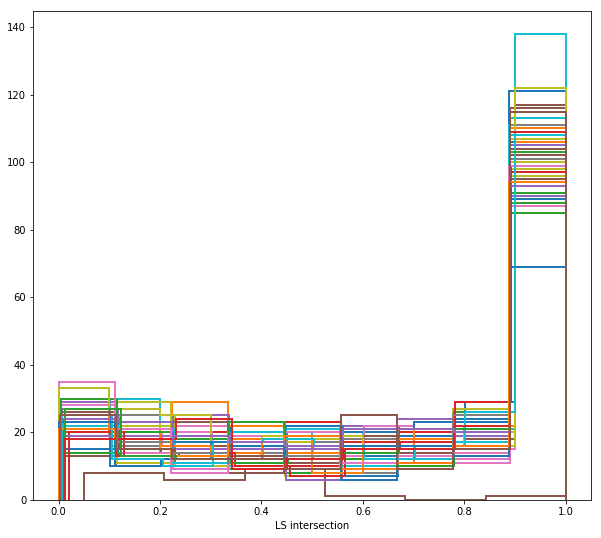

In [15]:
plt.figure(figsize=(10,9))
for key in bundleDicts.keys():
    plt.hist(lam[key][np.where(lam[key]<1)],bins='auto', lw=2, histtype='step', label='{}'.format(key))
    plt.xlabel('LS intersection')
    #plt.ylabel('fraction (%)')
    #plt.legend()

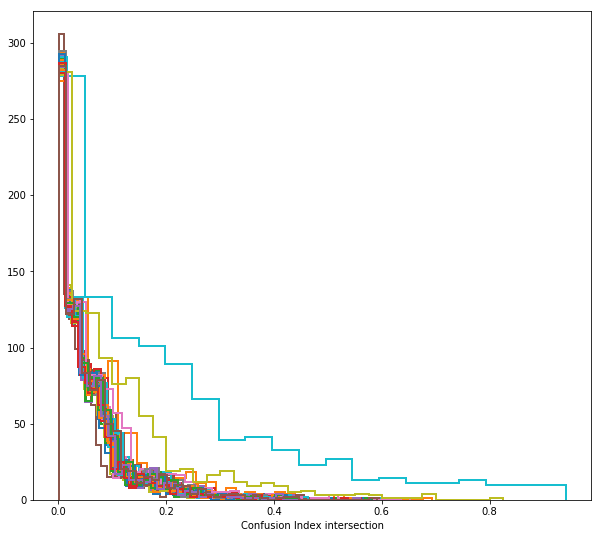

In [16]:
plt.figure(figsize=(10,9))
for key in bundleDicts.keys():
    plt.hist(conf[key],bins='auto', lw=2, histtype='step', label='{}'.format(key))
    plt.xlabel('Confusion Index intersection')
    #plt.ylabel('fraction (%)')
    #plt.legend()

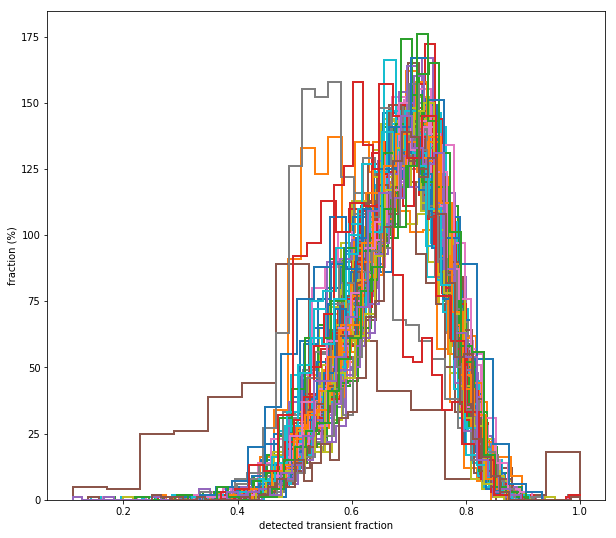

In [17]:
plt.figure(figsize=(10,9))
for key in bundleDicts.keys():
    plt.hist(frac[key],bins='auto', lw=2, histtype='step', label='{}'.format(key))
    plt.xlabel('detected transient fraction')
    plt.ylabel('fraction (%)')
    #plt.legend()

In [11]:
lam =pd.read_csv('LS_data_fom.csv', header=0)
frac =pd.read_csv('TransFrac_data_fom.csv', header=0)
conf =pd.read_csv('ConfIndex_data_fom.csv', header=0)

In [21]:
FomLS=[]
FomPMT=[]
FomC =[]
#for i, key in enumerate(bundleDicts.keys()):
for i, key in enumerate(dbRuns):
    ID_lam=np.where((lam[key]<1)& (np.isnan(lam[key])==False))
    ID_conf=np.where((conf[key]!=0)& (np.isnan(conf[key])==False))
    ID_frac=np.where((np.isnan(frac[key])==False))
    lv,lb =np.histogram(np.array(lam[key])[ID_lam],'auto')
    cv,cb =np.histogram(np.array(conf[key])[ID_conf],'auto')
    fv,fb=np.histogram(np.array(frac[key])[ID_frac],'auto')
    l_fom = (lb[1:len(lb)]+lb[0:len(lb)-1])/2*lv
    c_fom = (cb[1:len(cb)]+cb[0:len(cb)-1])/2*cv
    f_fom = (fb[1:len(fb)]+fb[0:len(fb)-1])/2*fv
    FomLS.append(l_fom.sum()/lv.sum()/(3*np.std(np.array(lam[key])[ID_lam])))
    FomPMT.append(f_fom.sum()/fv.sum())#/(3*np.std(np.array(frac[key])[ID_frac])))
    FomC.append(c_fom.sum()/cv.sum()/(3*np.std(np.array(conf[key])[ID_conf])))
FomLS=np.array(FomLS)
FomPMT=np.array(FomPMT)
FomC= np.array(FomC)

In [22]:
idx=np.argsort(FomC+FomPMT+FomLS)
idx=idx[::-1]

In [17]:
name_tick=[]
for key in bundleDicts.keys():
    n= key.split('_')
    if 'v1.4' in n:
        n.remove('v1.4')
    else:
        word=[]
        for s in n[-2]:
            word.append(s)
        word.remove('v')
        word.remove('1')
        word.remove('.')
        word.remove('4')
        sub =''
        n[-2]= sub.join(word)
    n.remove('10yrs')
    s=' '
    name_tick.append(s.join(n))

In [18]:
name_tick

['wfd depth scale0.85 noddf',
 'twilight neo mod2',
 'weather 0.3',
 'pair strategy 4']

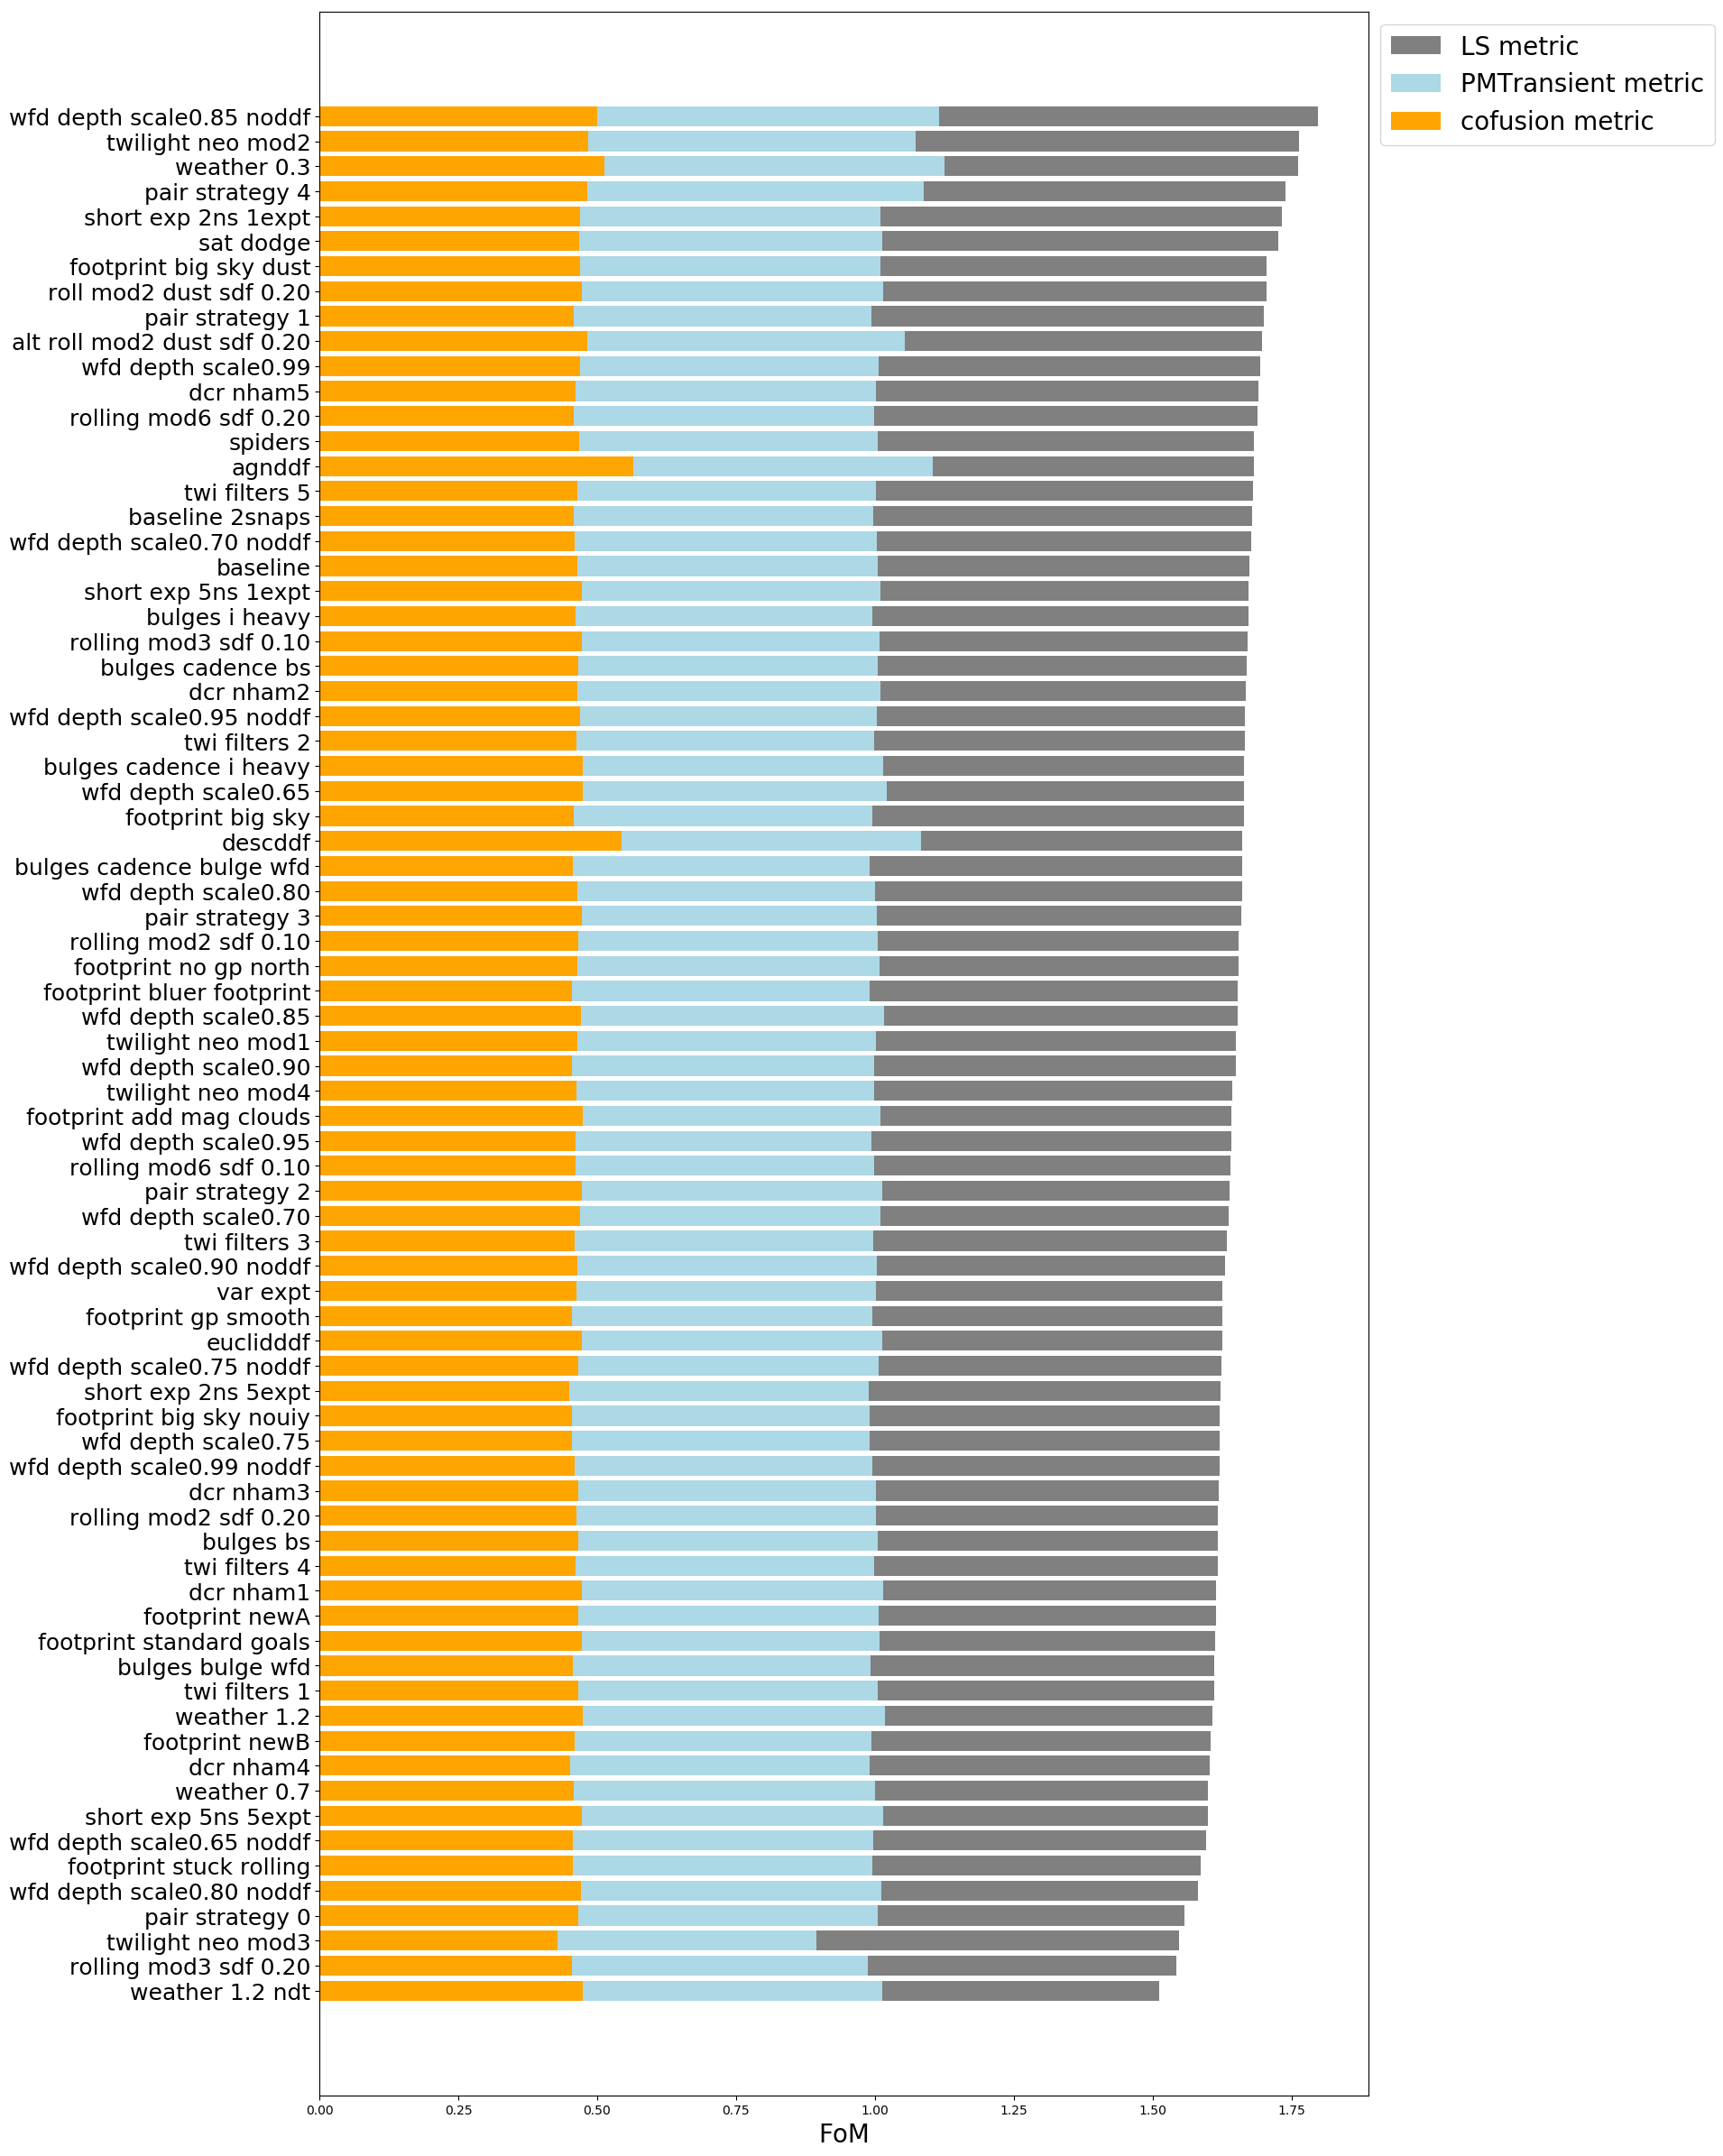

In [45]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15,30))
y_pos = np.arange(len(bundleDicts.keys()))
ax.barh(y_pos,FomLS[idx]+FomC[idx]+FomPMT[idx], align='center',color='grey',label='LS metric')
ax.barh(y_pos,FomPMT[idx]+FomC[idx], align='center',color='lightblue' ,label='PMTransient metric')
ax.barh(y_pos,FomC[idx], align='center', color= 'orange',label='cofusion metric')
ax.set_yticks(y_pos)
ax.set_yticklabels(name_tick, size=18)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('FoM', size=20)
ax.legend(bbox_to_anchor=(1., 1.),fontsize=20)
plt.savefig('FOM_metrics.png')

In [34]:
FomLS5=[]
FomPMT5=[]
FomC5 =[]
#for i, key in enumerate(bundleDicts.keys()):
for i, key in enumerate(dbRuns):
    ID_lam5=np.where((lam5[key]<1)& (np.isnan(lam5[key])==False))
    ID_conf5=np.where((conf5[key]!=0)& (np.isnan(conf5[key])==False))
    ID_frac5=np.where((np.isnan(frac5[key])==False))
    lv5,lb5 =np.histogram(np.array(lam5[key])[ID_lam5],'auto')
    cv5,cb5 =np.histogram(np.array(conf5[key])[ID_conf5],'auto')
    fv5,fb5=np.histogram(np.array(frac5[key])[ID_frac5],'auto')
    l5_fom = (lb5[1:len(lb5)]+lb5[0:len(lb5)-1])/2*lv5
    c5_fom = (cb5[1:len(cb5)]+cb5[0:len(cb5)-1])/2*cv5
    f5_fom = (fb5[1:len(fb5)]+fb5[0:len(fb5)-1])/2*fv5
    FomLS5.append(l5_fom.sum()/lv5.sum()/(3*np.std(np.array(lam5[key])[ID_lam5])))
    FomPMT5.append(f5_fom.sum()/fv5.sum())#/(3*np.std(np.array(frac[key])[ID_frac])))
    FomC5.append(c5_fom.sum()/cv5.sum()/(3*np.std(np.array(conf5[key])[ID_conf5])))
FomLS5=np.array(FomLS5)
FomPMT5=np.array(FomPMT5)
FomC5= np.array(FomC5)

In [35]:
idx5=np.argsort(FomC5+FomPMT5+FomLS5)
idx5=idx5[::-1]

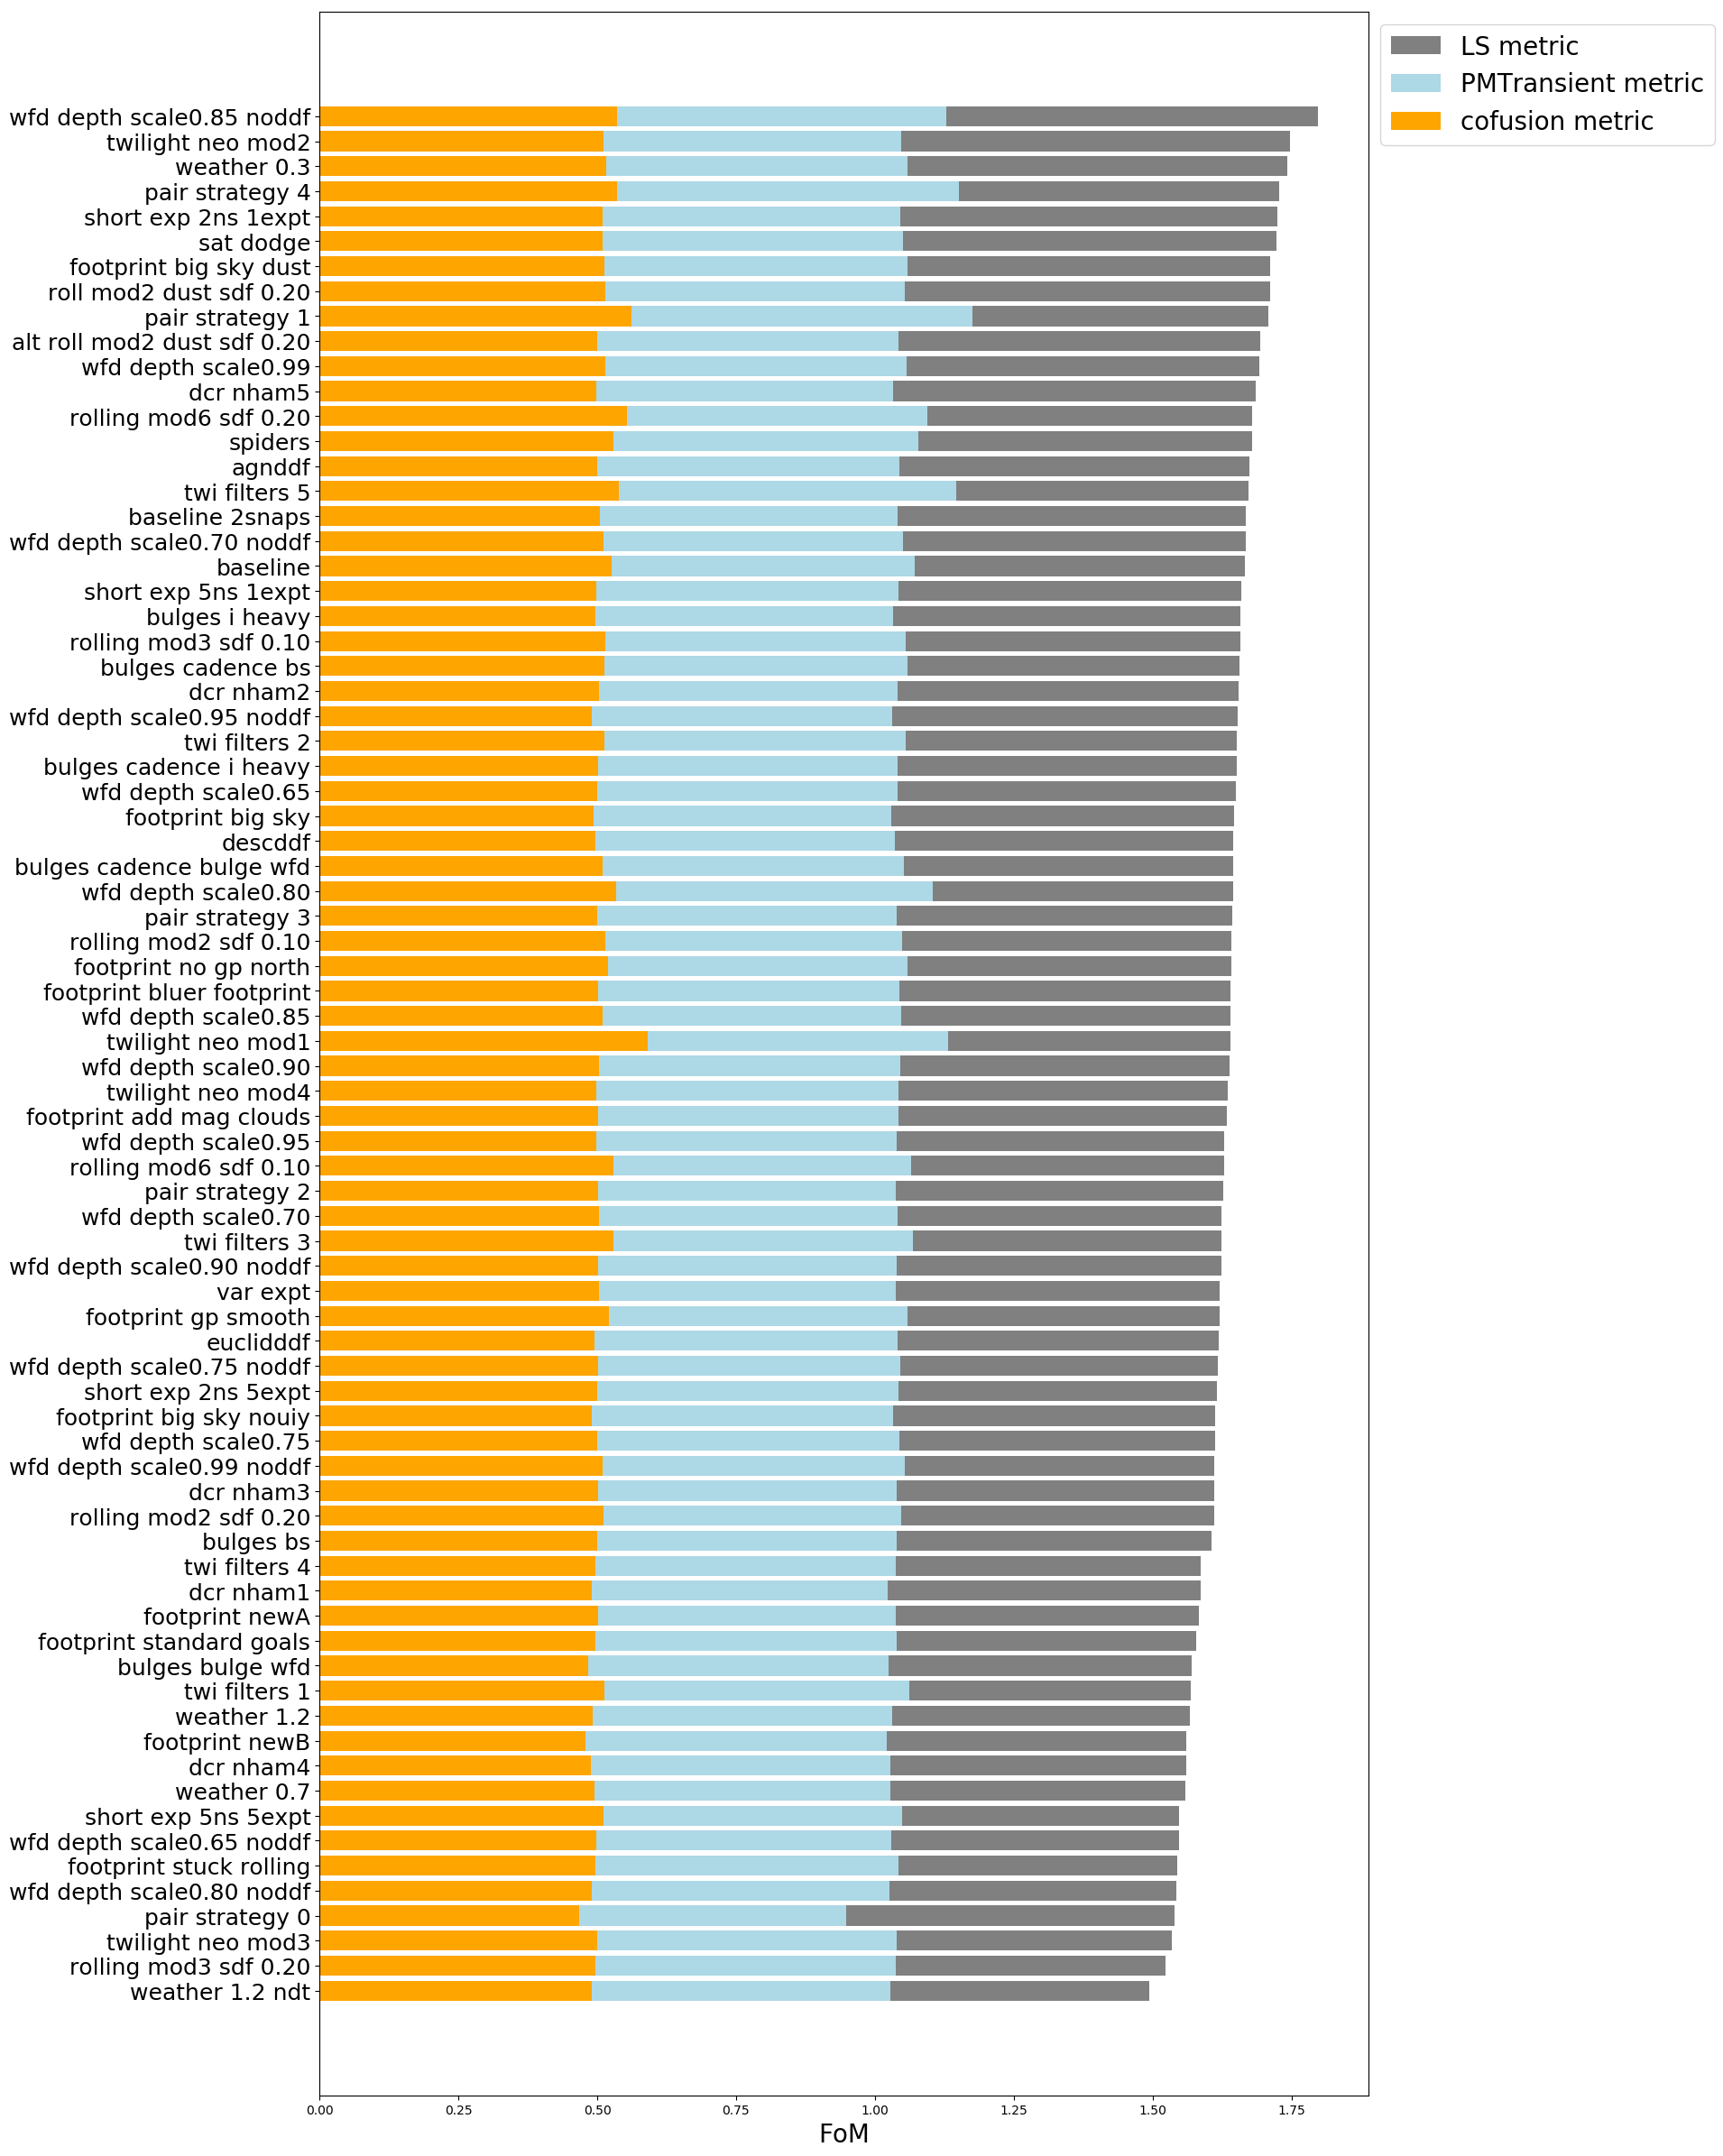

In [46]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15,30))
y_pos = np.arange(len(bundleDicts.keys()))
ax.barh(y_pos,FomLS5[idx5]+FomC5[idx5]+FomPMT5[idx5], align='center',color='grey',label='LS metric')
ax.barh(y_pos,FomPMT5[idx5]+FomC5[idx5], align='center',color='lightblue' ,label='PMTransient metric')
ax.barh(y_pos,FomC5[idx5], align='center', color= 'orange',label='cofusion metric')
ax.set_yticks(y_pos)
ax.set_yticklabels(name_tick, size=18)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('FoM', size=20)
ax.legend(bbox_to_anchor=(1., 1.),fontsize=20)
plt.savefig('FOM5_metrics.png')

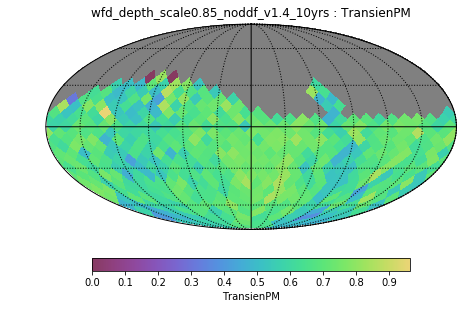

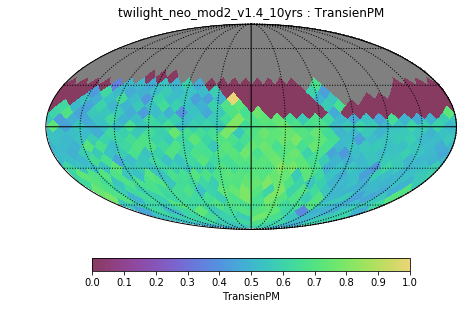

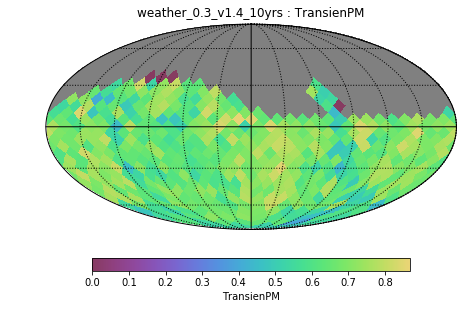

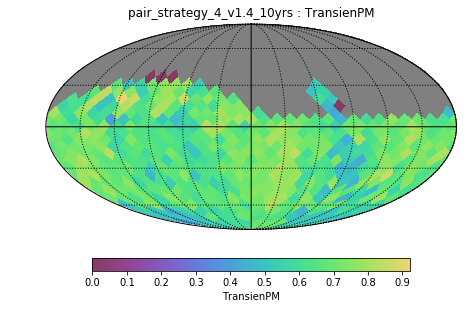

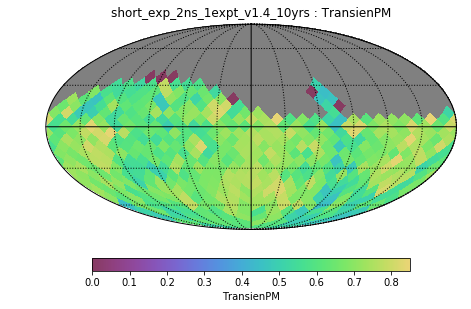

In [42]:
plotSky(bundleDicts, (2, 'TransienPM'))


In [34]:
data, hist  ={},{}
for key in bundleDicts.keys():
    data[key]=pd.DataFrame(bundleDicts[key][(1,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(1,'LSPMmetric')].metricValues.mask == False)])[0]
    hist[key]={}
    hist[key]['LS']=[]
    hist[key]['LS_out']=[]
    for i in range(len(data[key])):        
        if data[key][i]:
            for j in range(len(data[key][i]['LS']['LS_PM'])):
                hist[key]['LS'].append(data[key][i]['LS']['LS_PM'][j])
            for k in range(len(data[key][i]['LS']['LS_PMout'])):
                hist[key]['LS_out'].append(data[key][i]['LS']['LS_PMout'][k])
    hist[key]['LS']=np.hstack(np.array(hist[key]['LS']))
    hist[key]['LS_out']=np.hstack(np.array(hist[key]['LS_out']))

In [16]:
bundleDicts.keys()

dict_keys([])

In [15]:
import seaborn as sn

Text(0.5, 0.98, 'Baseline 5 yrs')

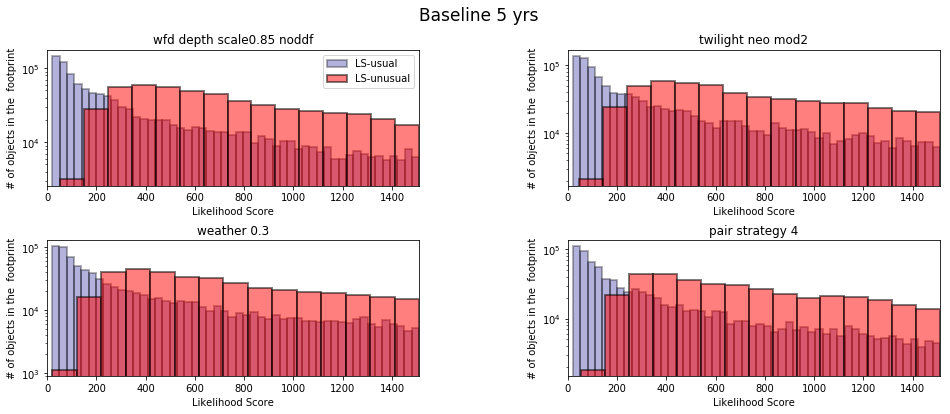

In [35]:
#fig = plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2, 2, figsize=(16,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, key in enumerate(dbRuns[0:4]):
    #value, bins = np.histogram(lam[key]['LS'], 50)
    #v_out, b_out = np.histogram(lam[key]['LS_out'],10)
    #ax = fig.add_subplot(2, 2, i+1)
    zeromaskLS =np.where(hist[key]['LS']!=0)
    plthist= pd.DataFrame(hist[key]['LS'][zeromaskLS])
    zeromask =np.where(hist[key]['LS_out']!=0)
    plthistout= pd.DataFrame(hist[key]['LS_out'][zeromask])
    sn.distplot(plthist, color="Darkblue", hist=True, kde=False,bins=50,hist_kws=dict(alpha=0.3,edgecolor="k", linewidth=2),ax=ax[i // 2][i % 2], label='LS-usual')
    sn.distplot(plthistout, color="red",  hist=True, kde=False,bins=15,hist_kws=dict(alpha=0.5,edgecolor="k", linewidth=2), ax=ax[i // 2][i % 2], label='LS-unusual')
    #ax.hist(lam[key]['LS'],10,alpha=.3,histtype='step',lw=3, color='black', label='LS-usual')
    #ax.hist(lam[key]['LS_out'],10,histtype='step',lw=3, color='orange', label='LS-unusual')
    ax[i // 2][i % 2].set_xlim([0,1510])
    ax[i // 2][i % 2].set_yscale('log')
    ax[i // 2][i % 2].set_xlabel('Likelihood Score')
    ax[i // 2][i % 2].set_ylabel('# of objects in the  footprint')
    ax[i // 2][i % 2].set_title('{}'.format(name_tick[i]))
    if i ==0:
        ax[i // 2][i % 2].legend()
plt.suptitle('Baseline 5 yrs', size=17)